# This notebook documents sign conventions

In [1]:
import pyproj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import celeri


In [2]:
# Global constants
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
M2MM = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)

## Read and process geometry files

In [3]:
COMMAND_FILE_NAME = "../data/config/japan_config.json"

config = celeri.Config.from_file(COMMAND_FILE_NAME)

# We manually read in the data so that we can override segment.burial_depth
# before we create the model
_segment, *_ = celeri.read_data(config)
_segment["burial_depth"] = 0

model = celeri.build_model(config, override_segment=_segment)

2025-06-12 15:18:49.695 | INFO     | celeri.model:read_data:52 - Reading data files
2025-06-12 15:18:49.701 | SUCCESS  | celeri.model:read_data:65 - Read: ../data/segment/qp_japan_segment.csv
2025-06-12 15:18:49.702 | SUCCESS  | celeri.model:read_data:70 - Read: ../data/block/japan_block.csv
2025-06-12 15:18:49.741 | SUCCESS  | celeri.mesh:from_params:468 - Read: ../data/mesh/nankai.msh
2025-06-12 15:18:49.751 | SUCCESS  | celeri.mesh:from_params:468 - Read: ../data/mesh/japan.msh
2025-06-12 15:18:49.759 | SUCCESS  | celeri.mesh:from_params:468 - Read: ../data/mesh/sagami.msh
2025-06-12 15:18:49.762 | SUCCESS  | celeri.model:read_data:107 - Read: ../data/station/japan_station.csv
2025-06-12 15:18:49.762 | SUCCESS  | celeri.model:read_data:127 - Read: ../data/mogi/japan_mogi.csv
2025-06-12 15:18:49.763 | INFO     | celeri.model:read_data:146 - No sar_file_name
2025-06-12 15:18:49.763 | INFO     | celeri.model:read_data:52 - Reading data files
2025-06-12 15:18:49.765 | SUCCESS  | celeri.

## Let's plot the index for each segment to make choosing segments easier

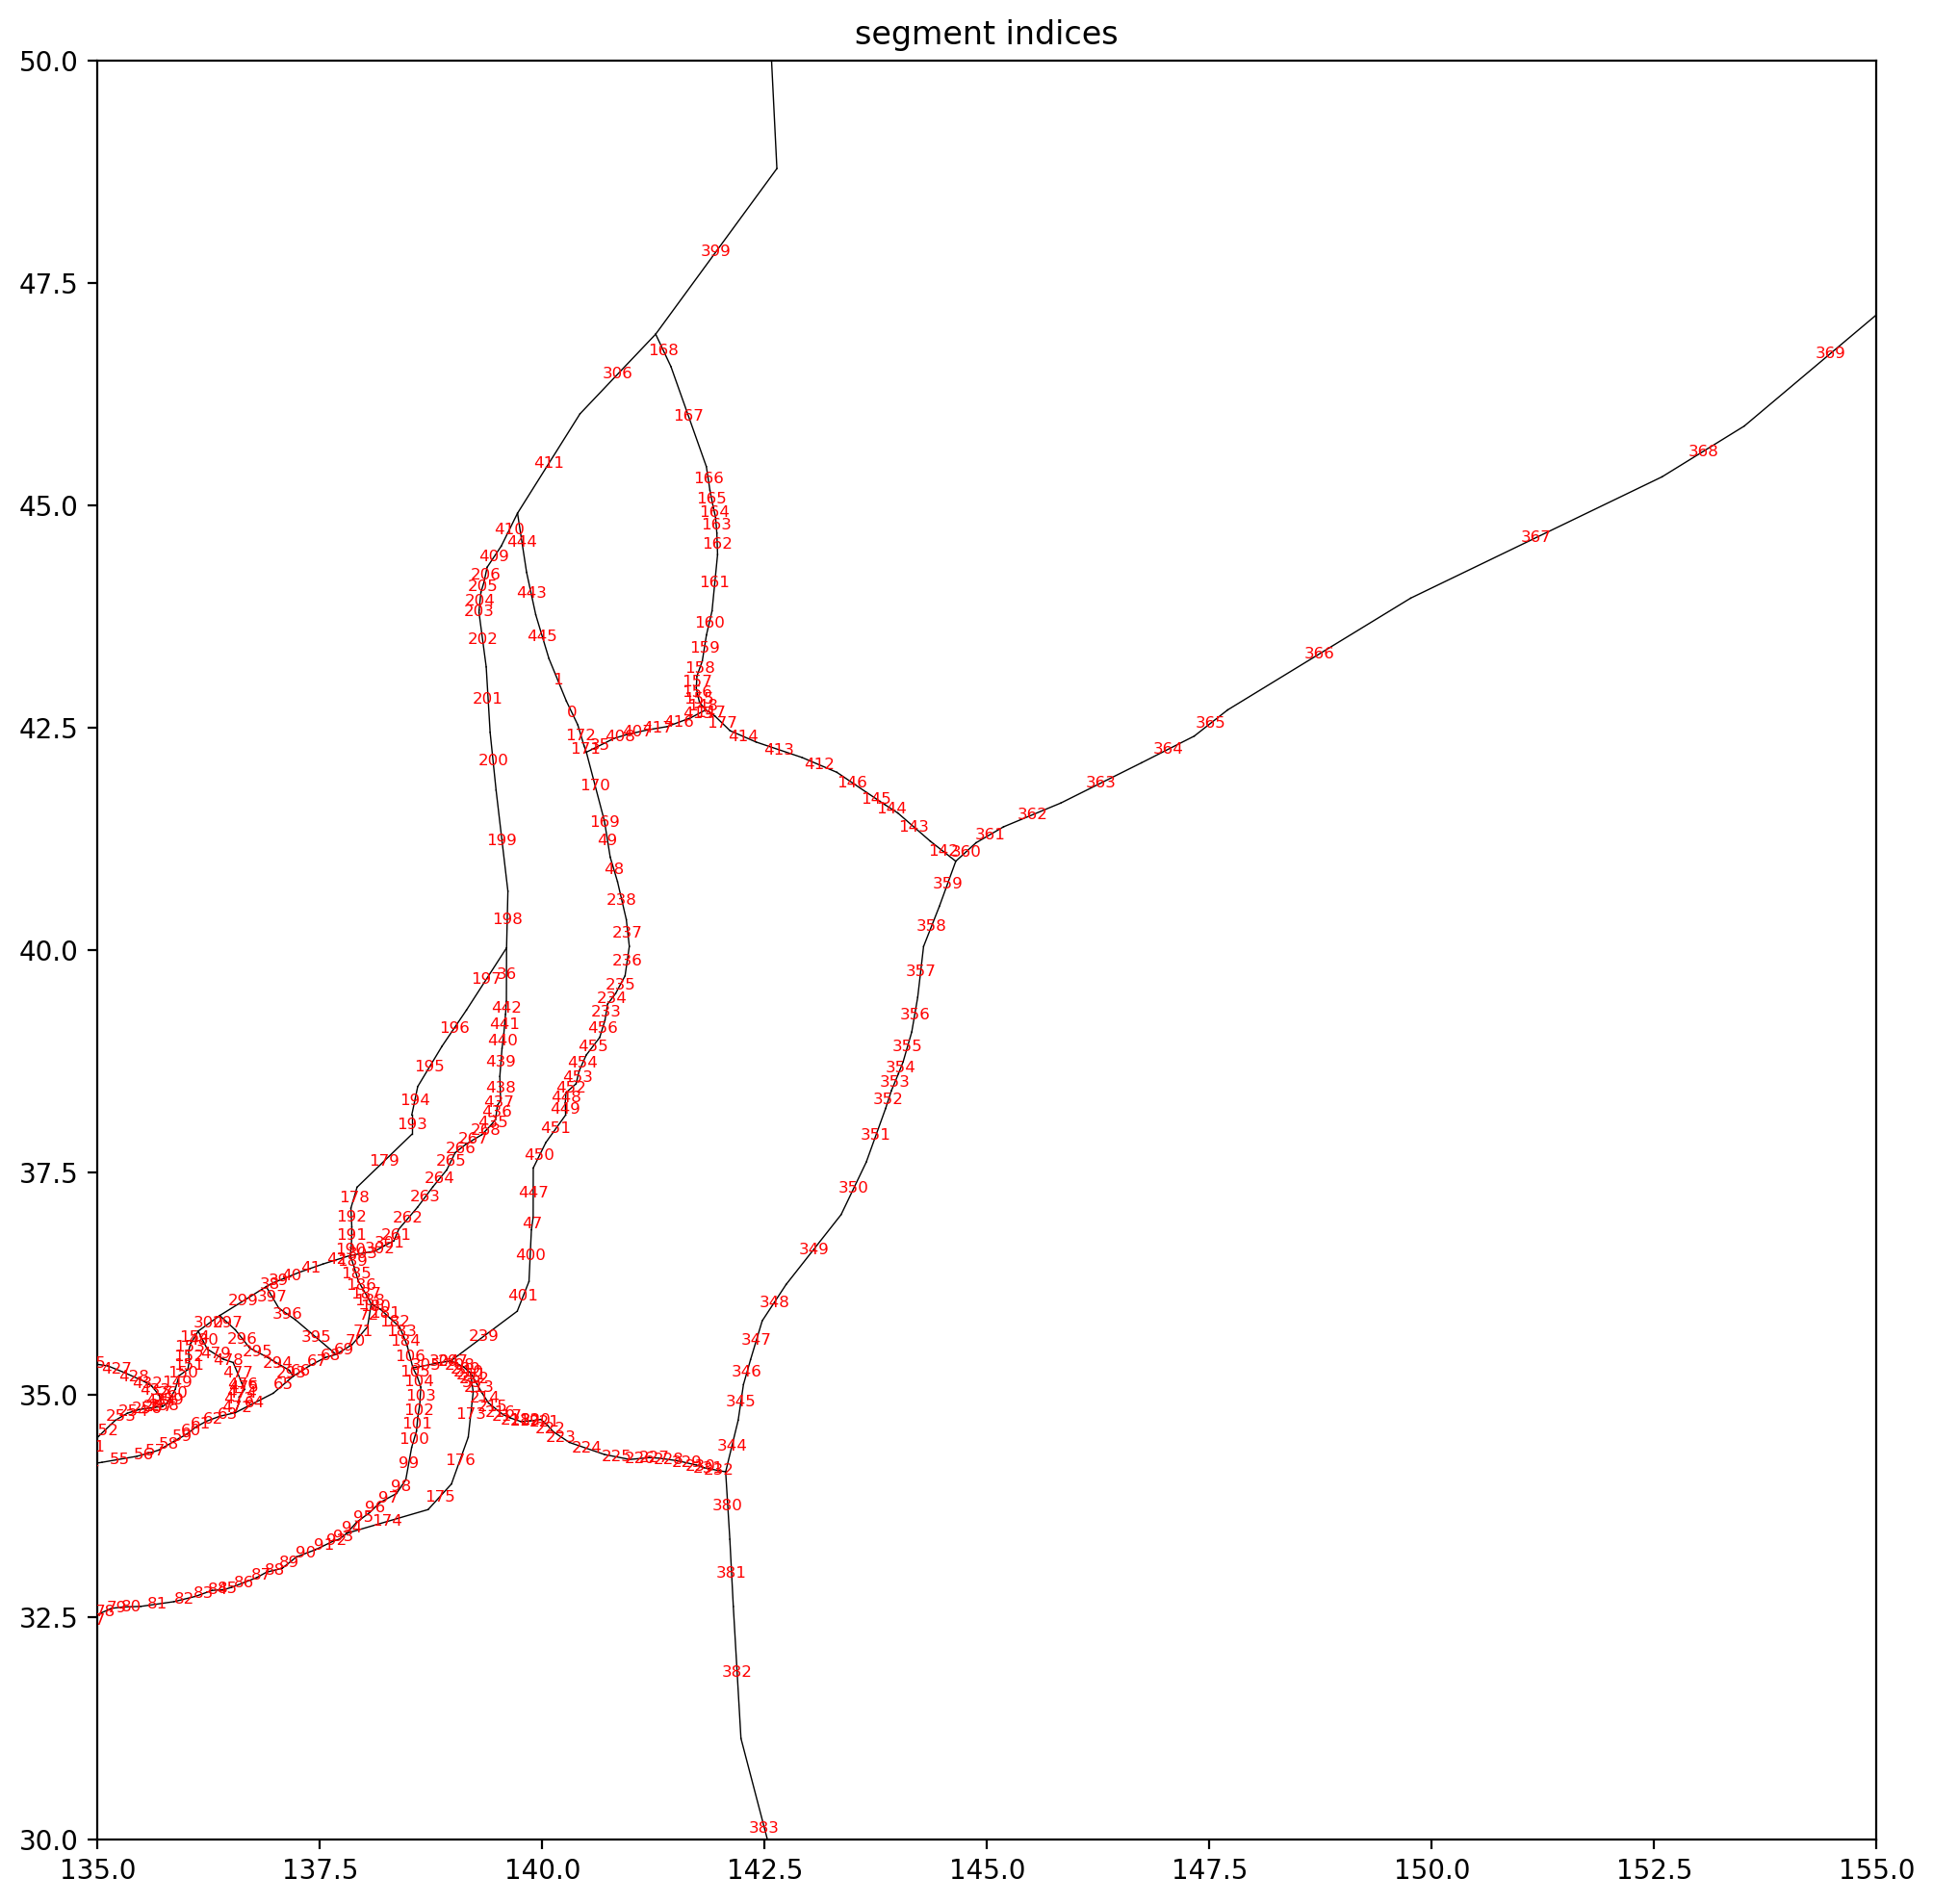

In [4]:
segment = model.segment

lon_min = 135
lon_max = 155
lat_min = 30
lat_max = 50

plt.figure(figsize=(12, 12))
for i in range(len(model.segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
    plt.text(
        segment.mid_lon_plate_carree[i],
        segment.mid_lat_plate_carree[i],
        str(i),
        color="r",
        clip_on=True,
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )
plt.xlim([lon_min, lon_max])
plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("segment indices")
plt.show()

## Calculate coordinates of fault bottom for visualization

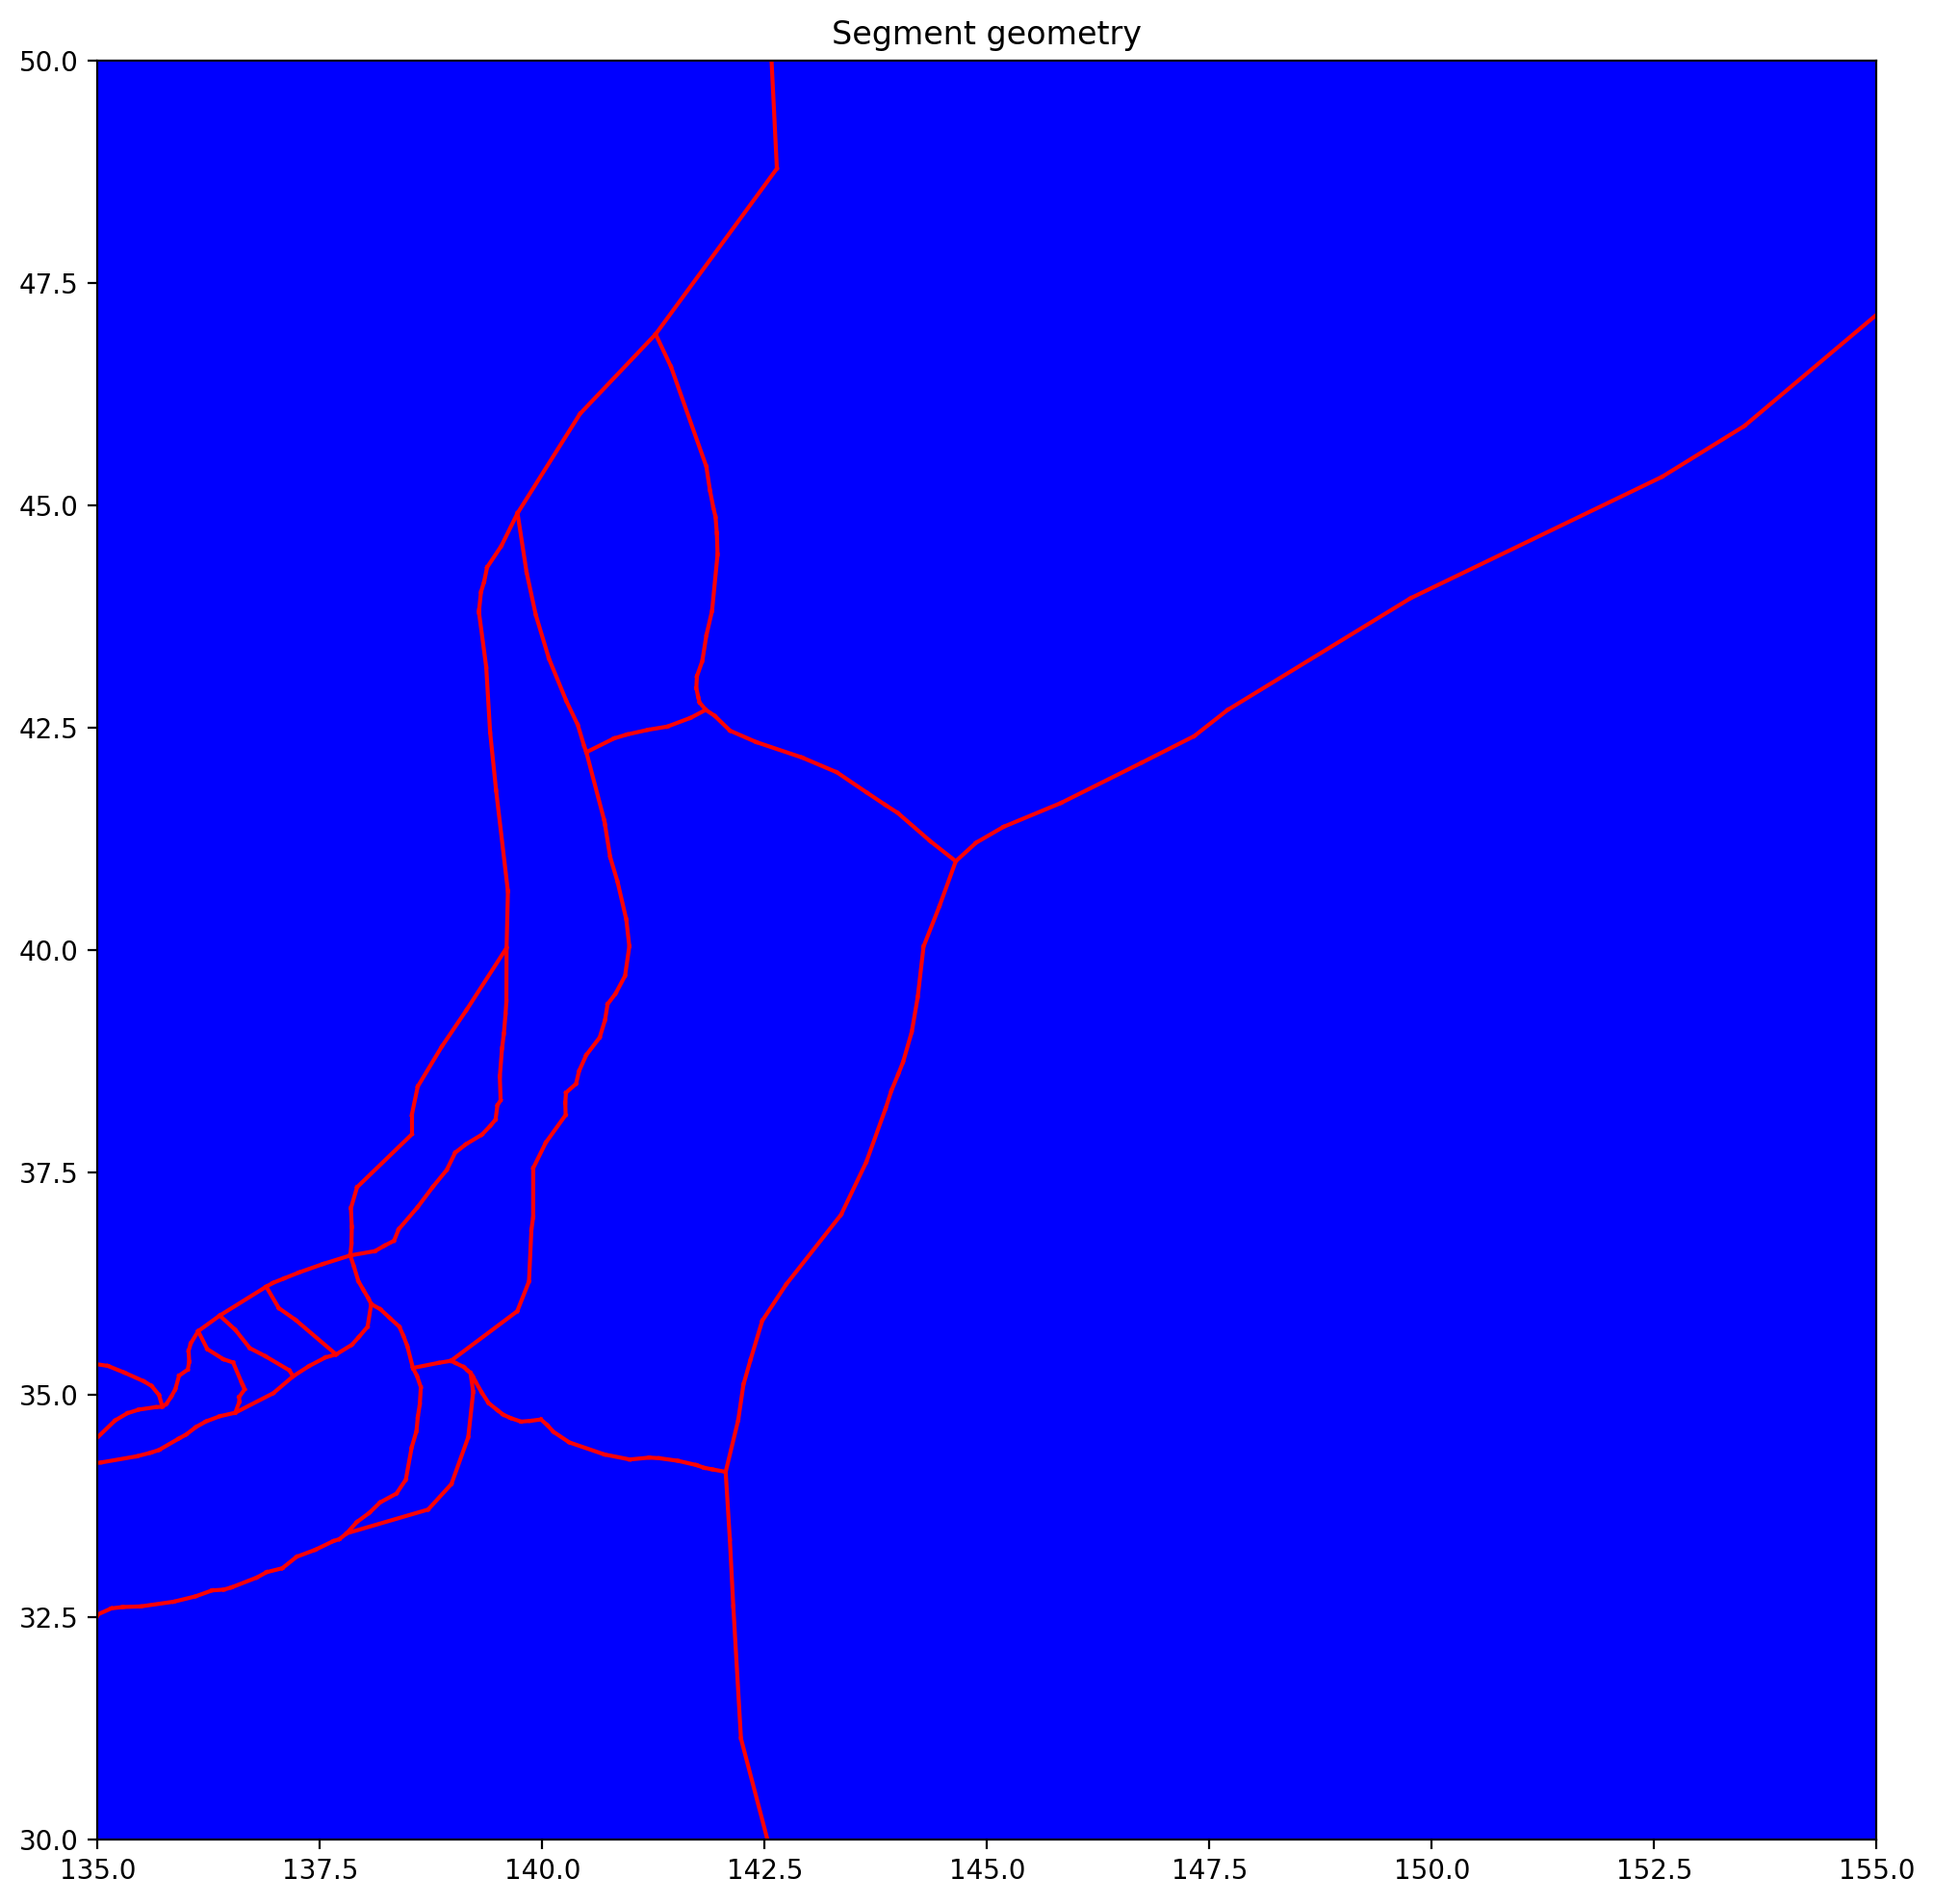

In [5]:
# Get bottom coordinates
width_projected = 1e3 * segment.locking_depth / np.tan(np.deg2rad(segment.dip))
lon1_bot = np.zeros(len(segment))
lon2_bot = np.zeros(len(segment))
lat1_bot = np.zeros(len(segment))
lat2_bot = np.zeros(len(segment))

for i in range(len(segment)):
    lon1_bot[i], lat1_bot[i], _ = GEOID.fwd(
        segment.lon1[i], segment.lat1[i], segment.azimuth[i] + 90, width_projected[i]
    )
    lon2_bot[i], lat2_bot[i], _ = GEOID.fwd(
        segment.lon2[i], segment.lat2[i], segment.azimuth[i] + 90, width_projected[i]
    )

# Check fault distances
checkdist = np.zeros_like(width_projected)
for i in range(len(segment)):
    _, _, checkdist[i] = GEOID.inv(
        segment.lon1[i], segment.lat1[i], lon1_bot[i], lat1_bot[i]
    )

fig, ax = plt.subplots(figsize=(12, 12))
for i in range(len(segment)):
    array = np.array(
        (
            (segment.lon1[i], segment.lat1[i]),
            (segment.lon2[i], segment.lat2[i]),
            (lon2_bot[i], lat2_bot[i]),
            (lon1_bot[i], lat1_bot[i]),
        )
    )
    plt.fill(array[:, 0], array[:, 1], "b")

plt.plot([segment.lon1, segment.lon2], [segment.lat1, segment.lat2], "-r")
plt.xlim([lon_min, lon_max])
plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Segment geometry")
plt.show()

## Choose a segment to visualize displacement fields

In [6]:
SEGMENT_IDX = 412
segment.dip.values[SEGMENT_IDX] = 45
segment.locking_depth.values[SEGMENT_IDX] = 20

# Make a copy of just this segment
this_segment = pd.DataFrame(columns=segment.columns, index=[0])
this_segment.loc[0] = segment.loc[SEGMENT_IDX]
print(this_segment.azimuth[0])

# Flip endpoints, so that eastern endpoint is first
this_segment_flipped = this_segment.copy(deep=True)
this_segment_flipped.lon1 = segment.lon2.values[SEGMENT_IDX]
this_segment_flipped.lat1 = segment.lat2.values[SEGMENT_IDX]
this_segment_flipped.lon2 = segment.lon1.values[SEGMENT_IDX]
this_segment_flipped.lat2 = segment.lat1.values[SEGMENT_IDX]
# Flip the segment's dip, so that it follows the RHR convention with flipped endpoints
this_segment_flipped.dip.values[0] = 180.0 - this_segment.dip[0]
# And recalculate segment azimuth
this_segment_flipped.loc[0, "azimuth"], _, _ = GEOID.inv(
    this_segment_flipped.lon1[0],
    this_segment_flipped.lat1[0],
    this_segment_flipped.lon2[0],
    this_segment_flipped.lat2[0],
)
print(this_segment_flipped.azimuth[0])

119.60982648571647
-60.12882248185419


## Make a dense observation grid that spans the fault

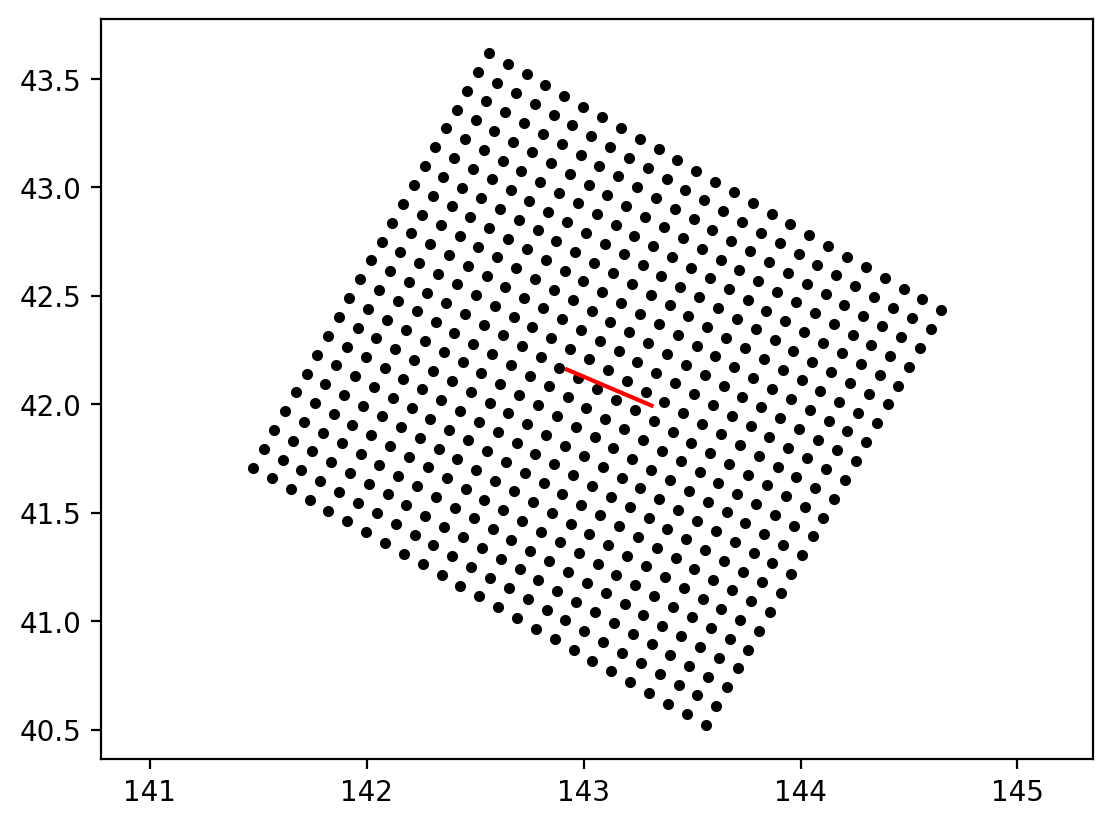

In [7]:
meanx = (this_segment.lon1[0] + this_segment.lon2[0]) / 2
meany = (this_segment.lat1[0] + this_segment.lat2[0]) / 2
# Coordinate vectors
x = np.arange(
    np.min([this_segment.lon1, this_segment.lon2]) - 1.05,
    np.max([this_segment.lon1, this_segment.lon2]) + 1.05,
    0.1,
)
y = np.arange(
    np.min([this_segment.lat1, this_segment.lat2]) - 1.05,
    np.max([this_segment.lat1, this_segment.lat2]) + 1.05,
    0.1,
)
# Meshgrid
xg, yg = np.meshgrid(x - meanx, y - meany)

# Rotate meshgrid by strike
cosstrike = np.cos(np.radians(this_segment.azimuth[0]))
sinstrike = np.sin(np.radians(this_segment.azimuth[0]))
xr = xg * sinstrike - yg * cosstrike + meanx
yr = xg * cosstrike + yg * sinstrike + meany

# Place into station df
gridsta = pd.DataFrame(columns=["lon", "lat"])
gridsta.lon = np.reshape(xr, -1)
gridsta.lat = np.reshape(yr, -1)

# Plot to check
fig, ax = plt.subplots()
ax.plot(xr, yr, ".k")
ax.plot(
    [this_segment.lon1[0], this_segment.lon2[0]],
    [this_segment.lat1[0], this_segment.lat2[0]],
    "r",
)

plt.axis("equal")
plt.show()

## Plot displacements due to unit slip

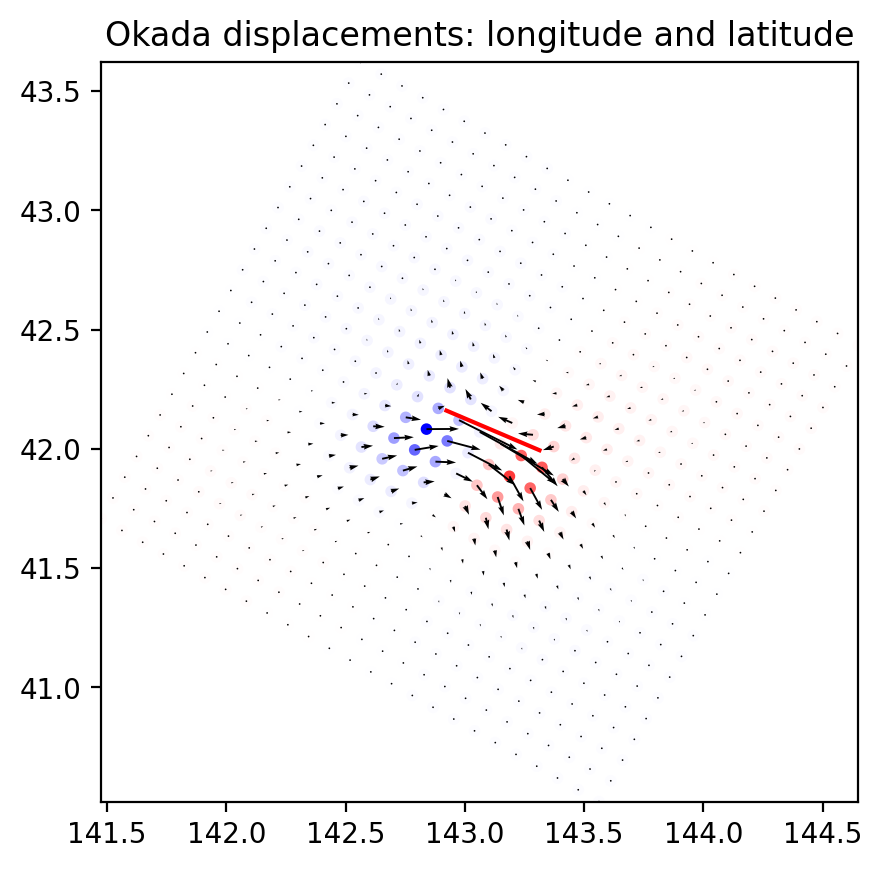

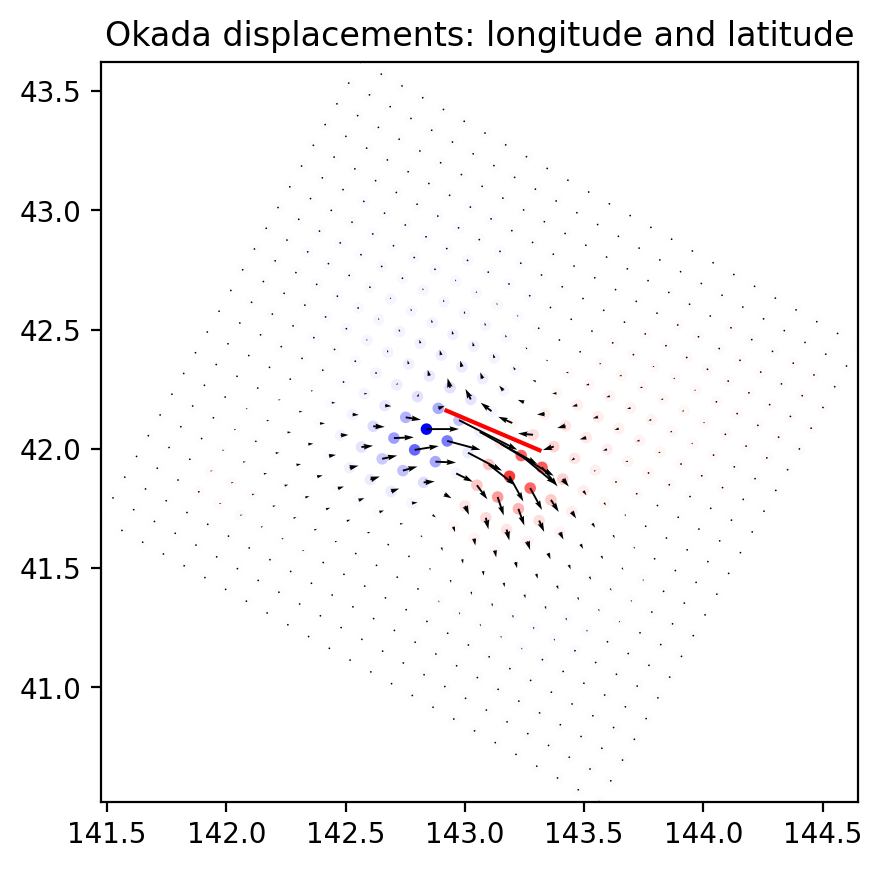

In [8]:
# strike-slip
celeri.plot_segment_displacements(
    this_segment,
    gridsta,
    model.config,
    segment_idx=0,
    strike_slip=1,
    dip_slip=0,
    tensile_slip=0,
    lon_min=np.min(gridsta.lon),
    lon_max=np.max(gridsta.lon),
    lat_min=np.min(gridsta.lat),
    lat_max=np.max(gridsta.lat),
    quiver_scale=2e0,
)
# strike-slip
celeri.plot_segment_displacements(
    this_segment_flipped,
    gridsta,
    model.config,
    segment_idx=0,
    strike_slip=1,
    dip_slip=0,
    tensile_slip=0,
    lon_min=np.min(gridsta.lon),
    lon_max=np.max(gridsta.lon),
    lat_min=np.min(gridsta.lat),
    lat_max=np.max(gridsta.lat),
    quiver_scale=2e0,
)

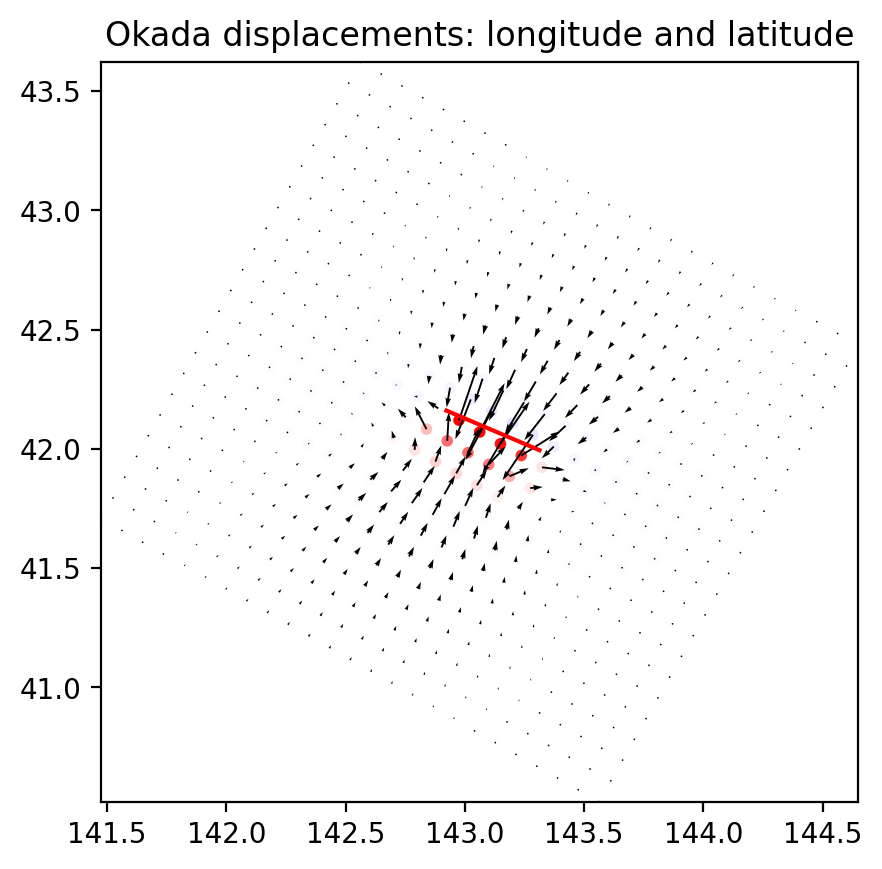

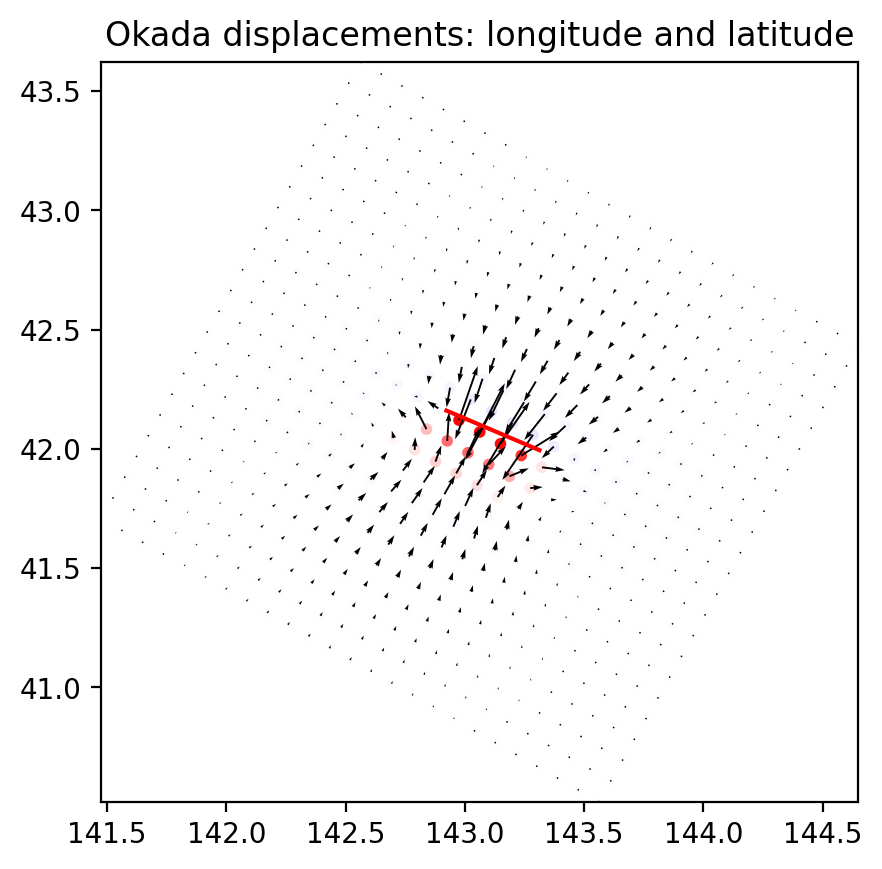

In [9]:
# dip-slip
celeri.plot_segment_displacements(
    this_segment,
    gridsta,
    model.config,
    segment_idx=0,
    strike_slip=0,
    dip_slip=1,
    tensile_slip=0,
    lon_min=np.min(gridsta.lon),
    lon_max=np.max(gridsta.lon),
    lat_min=np.min(gridsta.lat),
    lat_max=np.max(gridsta.lat),
    quiver_scale=1e0,
)
# dip-slip
celeri.plot_segment_displacements(
    this_segment_flipped,
    gridsta,
    model.config,
    segment_idx=0,
    strike_slip=0,
    dip_slip=1,
    tensile_slip=0,
    lon_min=np.min(gridsta.lon),
    lon_max=np.max(gridsta.lon),
    lat_min=np.min(gridsta.lat),
    lat_max=np.max(gridsta.lat),
    quiver_scale=1e0,
)

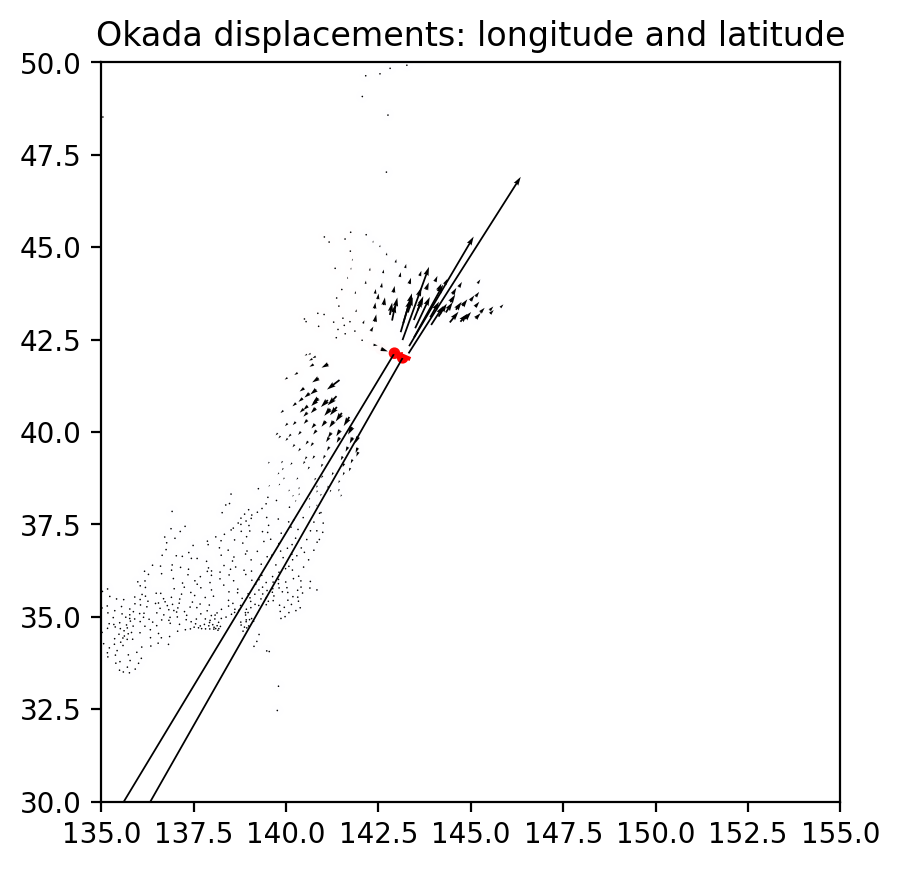

In [10]:
# tensile-slip
celeri.plot_segment_displacements(
    model.segment,
    model.station,
    model.config,
    segment_idx=SEGMENT_IDX,
    strike_slip=0,
    dip_slip=0,
    tensile_slip=1,
    lon_min=135,
    lon_max=155,
    lat_min=30,
    lat_max=50,
    quiver_scale=1e-1,
)

# Summary of Okada slip rate conventions:
- ## Locking depth is positive down  
| type | sign | interpretation |
| - | - | - |
| strike-slip | positive | left-lateral |
| strike-slip | negative | right-lateral |
| dip-slip | positive | convergence |
| dip-slip | negative | extension |
| tensile-slip | positive | extension |
| tensile-slip | negative | convergence |
- ## Note: The difference in sign for convergence and extension for dip-slip and tensile-slip is not idea but it seems consistent with Okada?  Should I change this so that it is more intiutive (e.g., positive numbers are always convergence) or leave as is for consistency with Okada?


# Now let's take a look at differential block velocities

In [11]:
station = model.station
sar = model.sar
block = model.block

SEGMENT_IDX = 65
segment.dip.values[SEGMENT_IDX] = 45
segment.locking_depth.values[SEGMENT_IDX] = 50


operators = celeri.build_operators(model, tde=False, eigen=False)

2025-06-12 15:18:51.003 | WARNING  | celeri.operators:_store_elastic_operators:535 - Precomputed elastic operator file not found
2025-06-12 15:18:51.003 | INFO     | celeri.operators:_store_elastic_operators:536 - Computing elastic operators
Calculating Okada partials for segments: 100%|██████████| 481/481 [00:03<00:00, 156.53it/s]
2025-06-12 15:18:54.093 | INFO     | celeri.operators:_store_elastic_operators:544 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh
Calculating cutde partials for triangles: 100%|██████████| 1902/1902 [00:02<00:00, 746.61it/s]
2025-06-12 15:18:56.641 | SUCCESS  | celeri.operators:_store_elastic_operators:550 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh
2025-06-12 15:18:56.642 | INFO     | celeri.operators:_store_elastic_operators:544 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh
Calculating cutde partials for triangles: 100%|██████████| 2621/2621 [00:03<00:00, 731.65it/s]

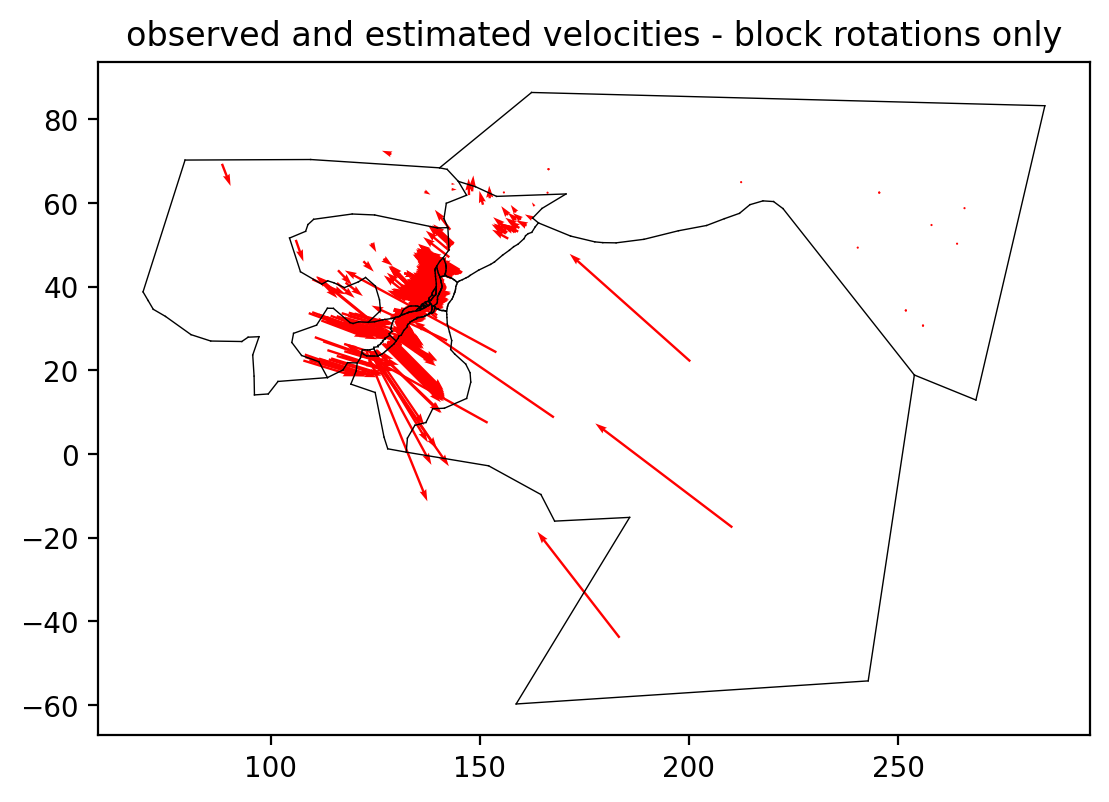

In [12]:
assembly = operators.assembly

# Rotations only - with JDF a priori and no global float
data_vector = np.zeros(
    2 * assembly.data.n_stations + 3 * assembly.data.n_block_constraints
)
data_vector[0 : 2 * assembly.data.n_stations] = celeri.interleave2(
    assembly.data.east_vel, assembly.data.north_vel
)

# Add block motion costraints to data vector
data_vector[
    2 * assembly.data.n_stations : 2 * assembly.data.n_stations
    + 3 * assembly.data.n_block_constraints
] = assembly.data.block_constraints
data_vector[
    2 * assembly.data.n_stations : 2 * assembly.data.n_stations
    + 3 * assembly.data.n_block_constraints
] = 0

operator = np.zeros(
    (
        2 * assembly.data.n_stations + 3 * assembly.data.n_block_constraints,
        3 * len(block),
    )
)
operator[0 : 2 * assembly.data.n_stations, :] = np.delete(
    operators.rotation_to_velocities,
    np.arange(2, operators.rotation_to_velocities.shape[0], 3),
    axis=0,
)  # Delete up velocity partials
operator[
    2 * assembly.data.n_stations : 2 * assembly.data.n_stations
    + 3 * assembly.data.n_block_constraints,
    :,
] = operators.block_motion_constraints

estimation = dict()
state_vector = np.linalg.inv(operator.T @ operator) @ operator.T @ data_vector
estimation["predictions"] = operator @ state_vector
vel = estimation["predictions"][0 : 2 * assembly.data.n_stations]
estimation["east_vel"] = vel[0::2]
estimation["north_vel"] = vel[1::2]
east_vel_rotation_only = vel[0::2]
north_vel_rotation_only = vel[1::2]

# Plot observed and estimated velocities
lon_min = 235
lon_max = 255
lat_min = 30
lat_max = 50
quiver_scale = 1e2
plt.figure()
for i in range(len(segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
# plt.quiver(station.lon, station.lat, station.east_vel, station.north_vel, scale=quiver_scale, scale_units="inches", color="g")
plt.quiver(
    station.lon,
    station.lat,
    estimation["east_vel"],
    estimation["north_vel"],
    scale=quiver_scale,
    scale_units="inches",
    color="r",
)
# plt.xlim([lon_min, lon_max])
# plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("observed and estimated velocities - block rotations only")
plt.show()

# Convert estimated block motions to fault slip rates

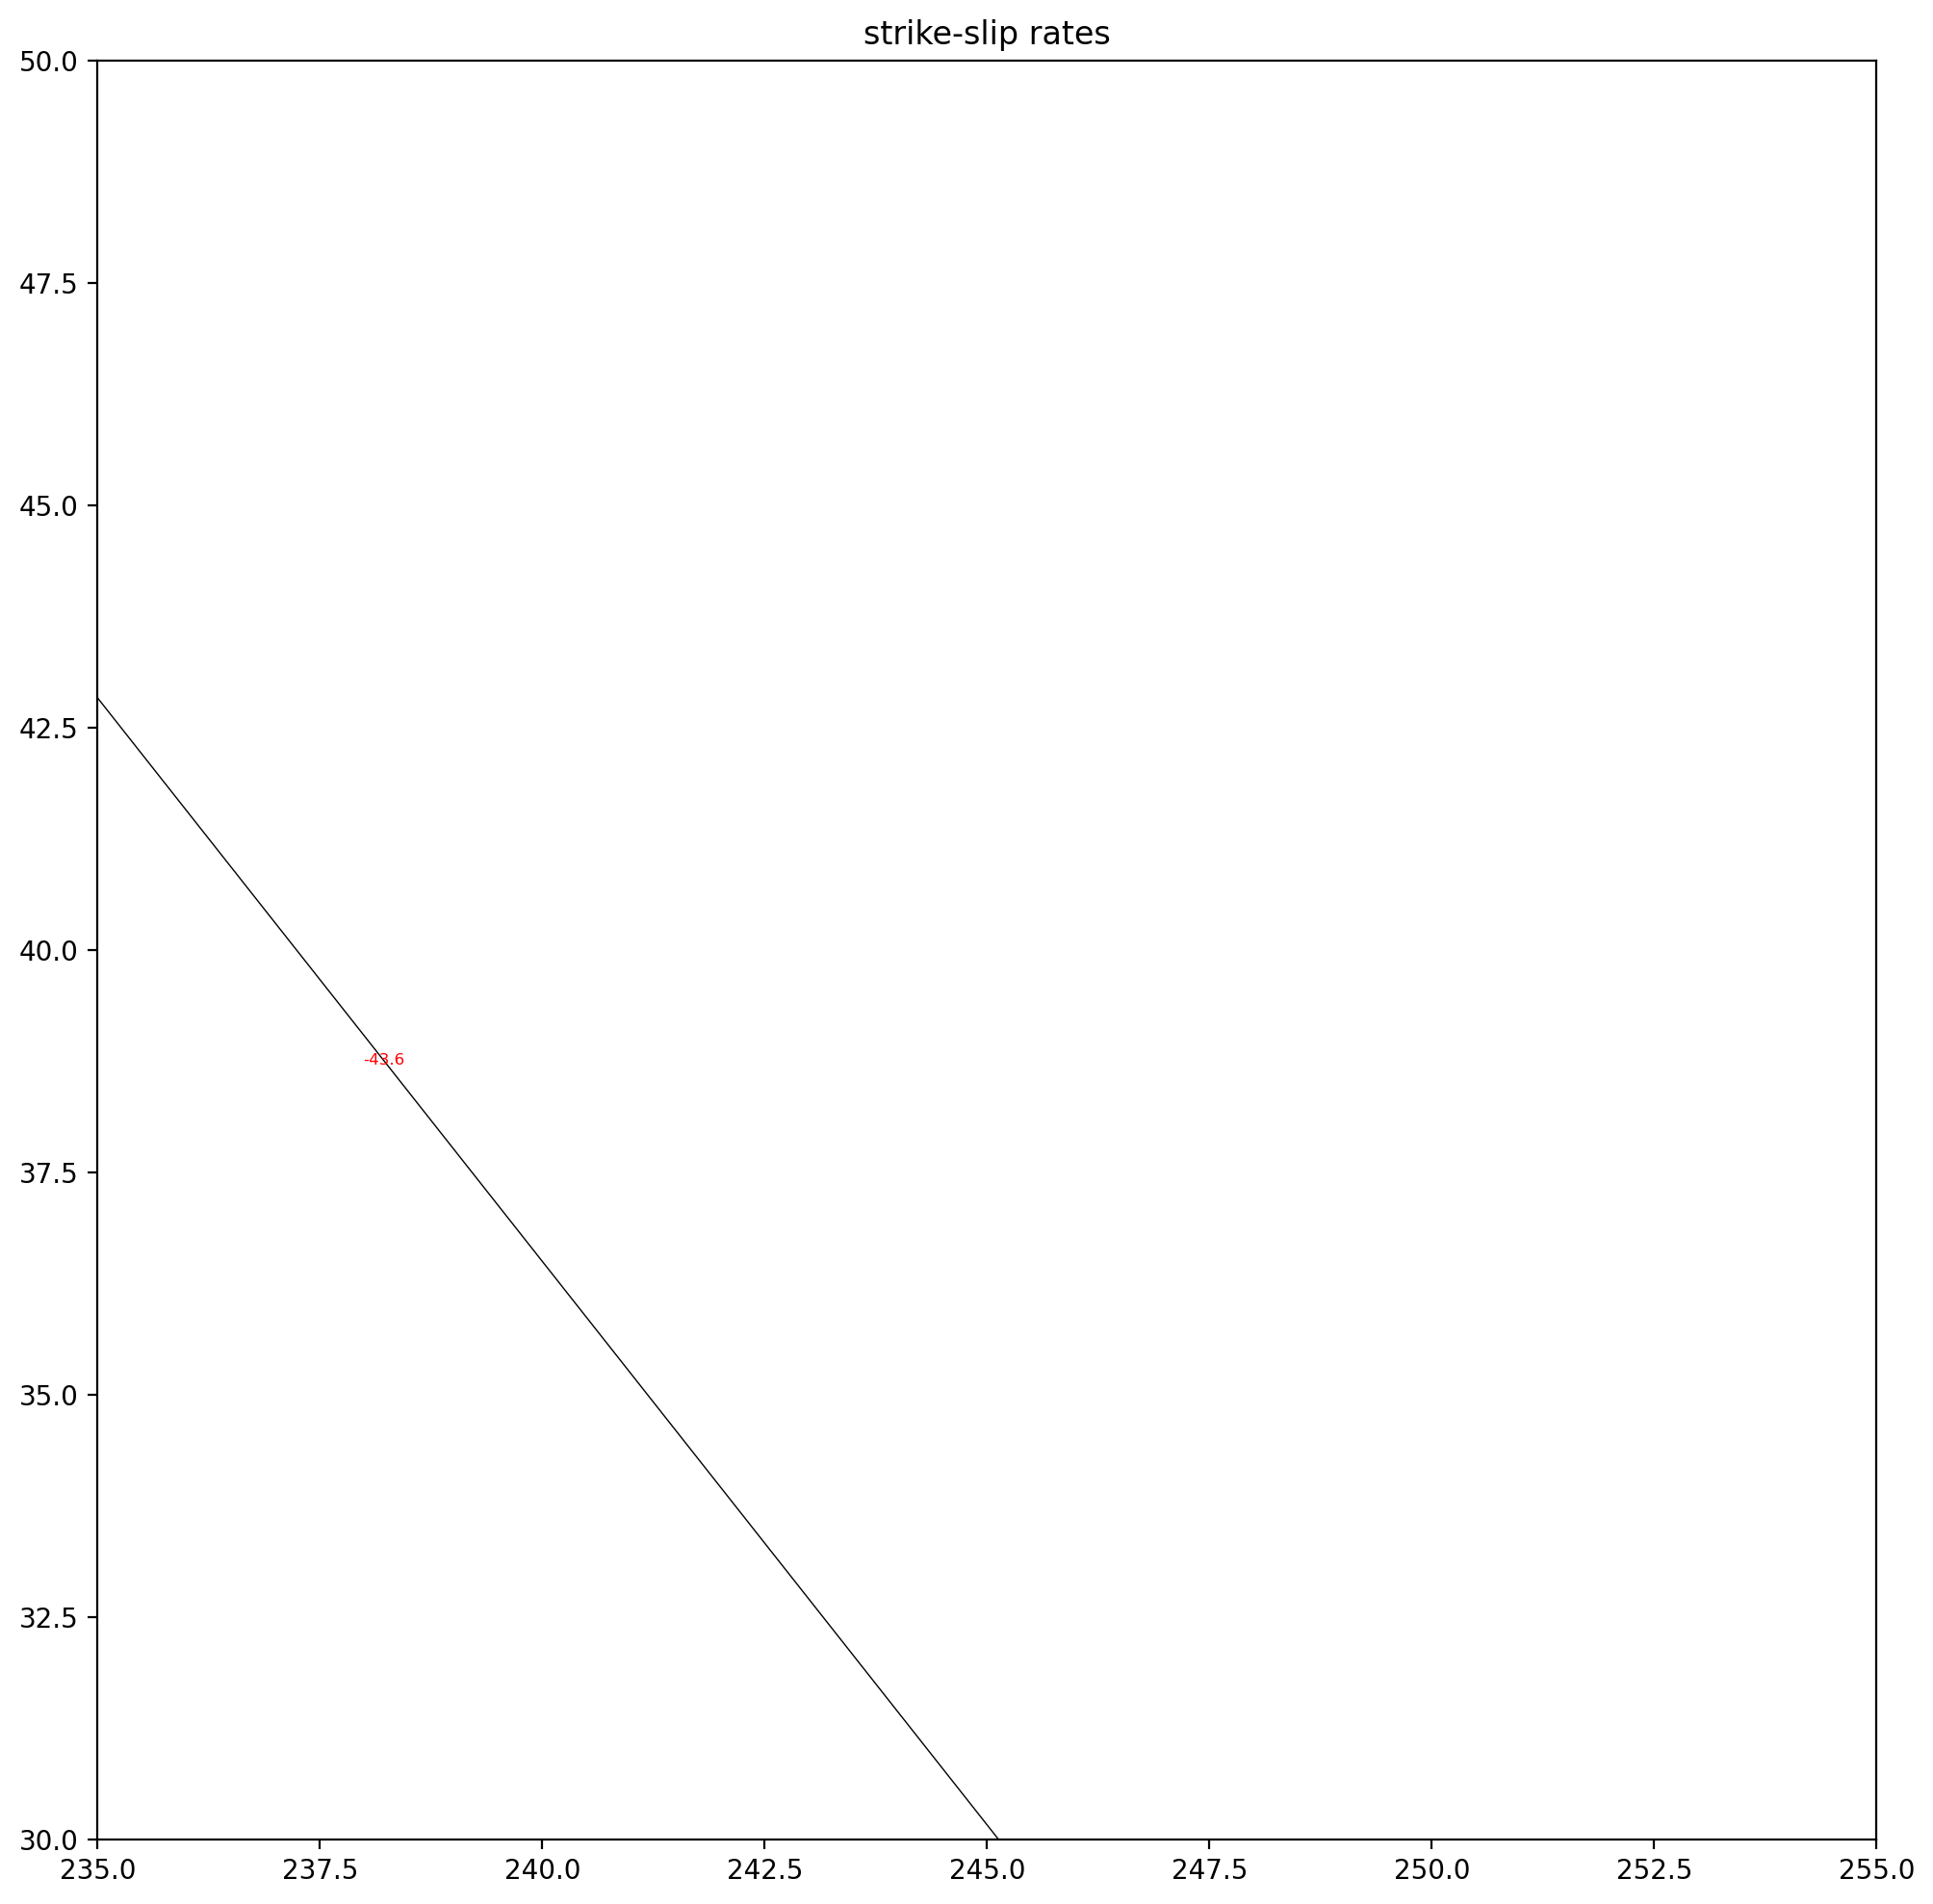

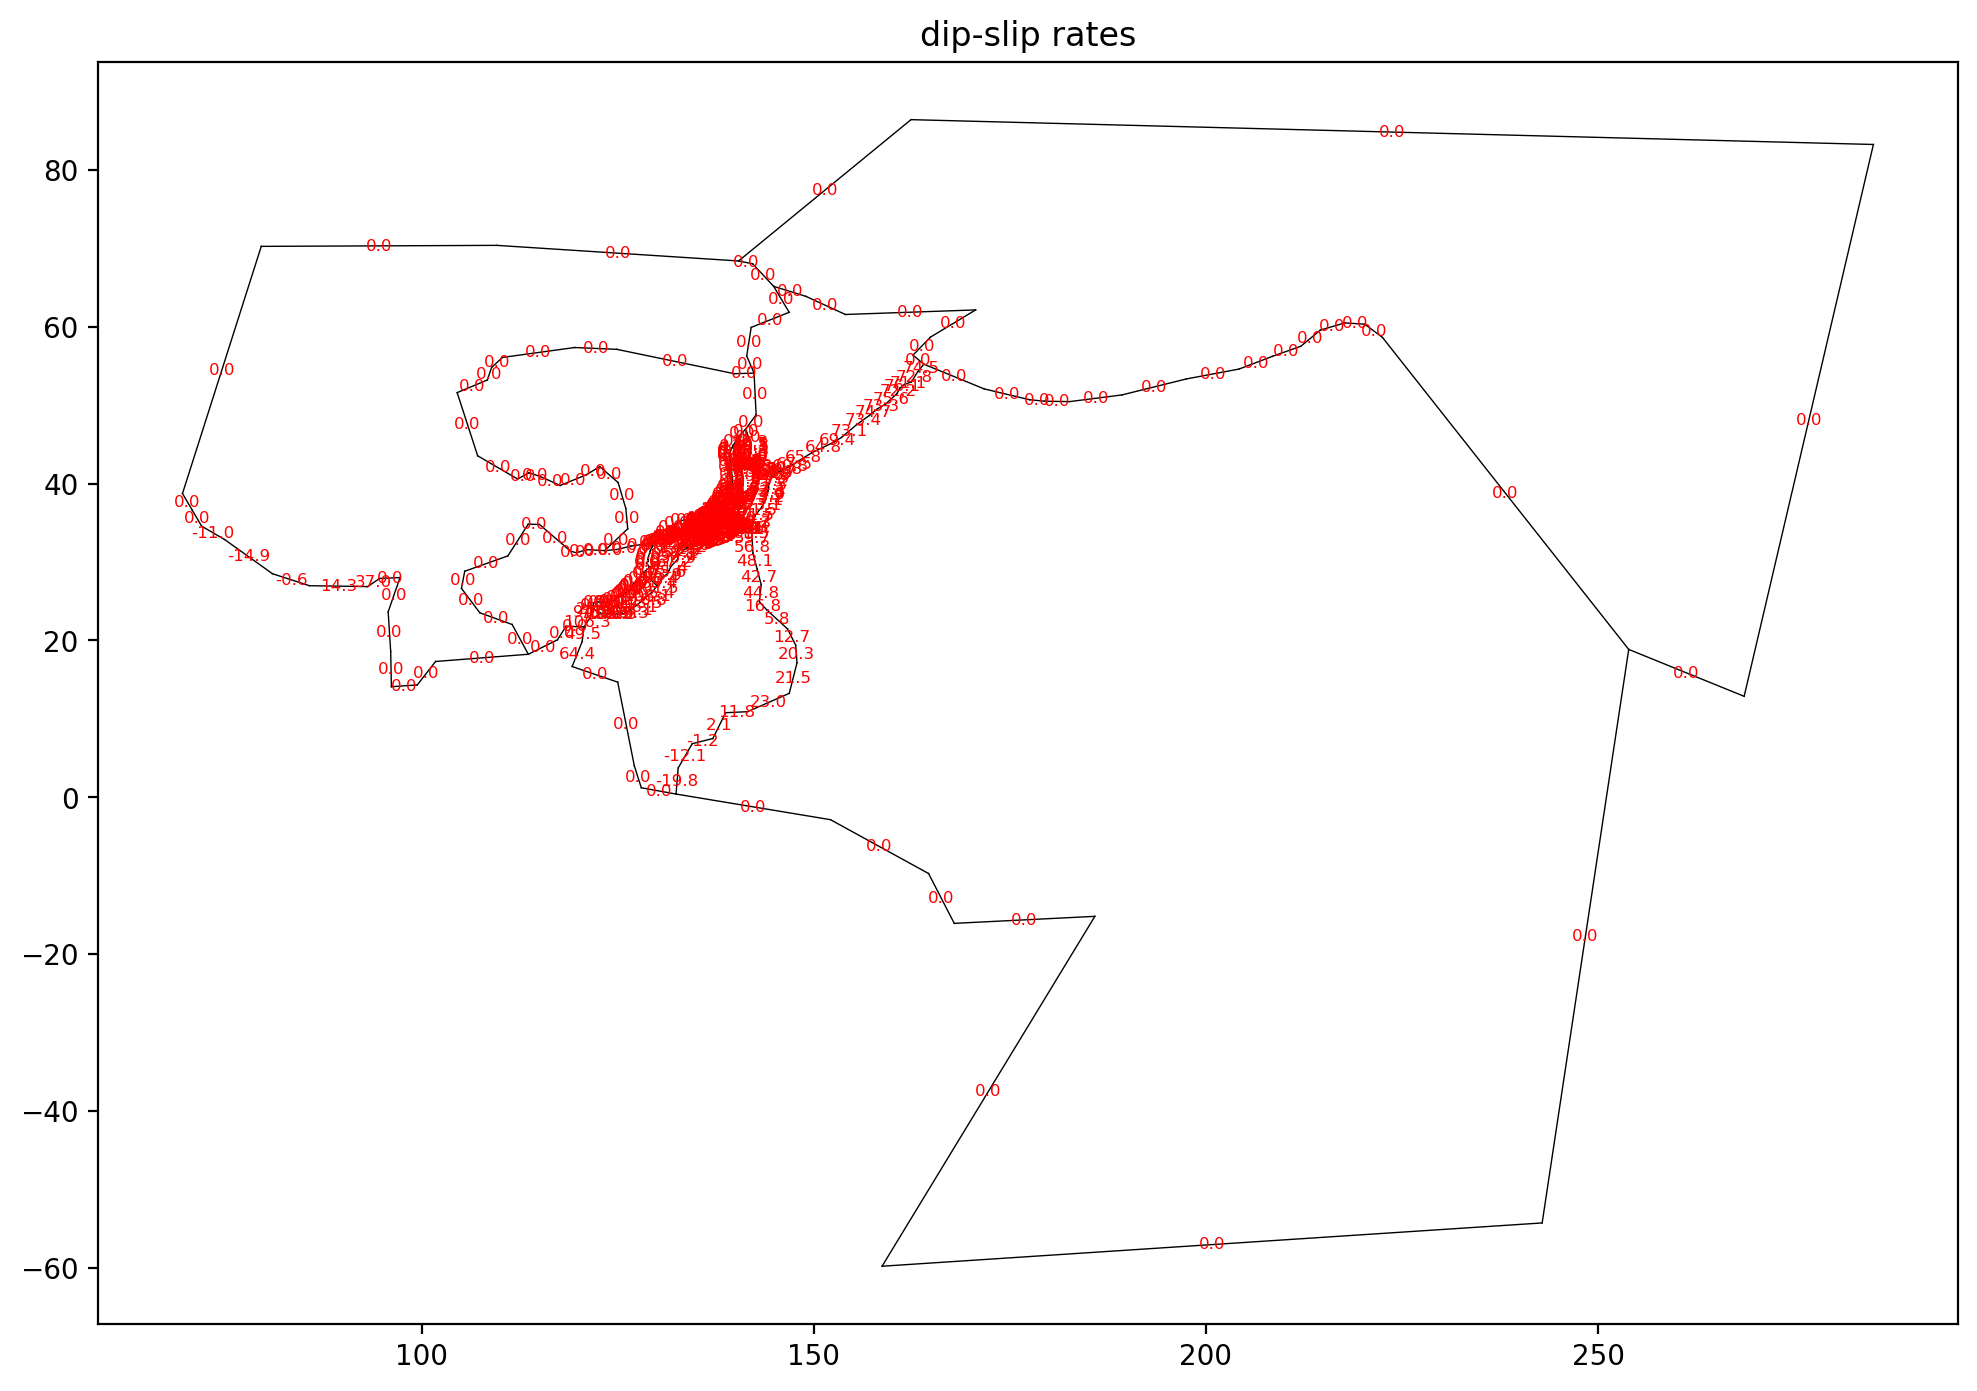

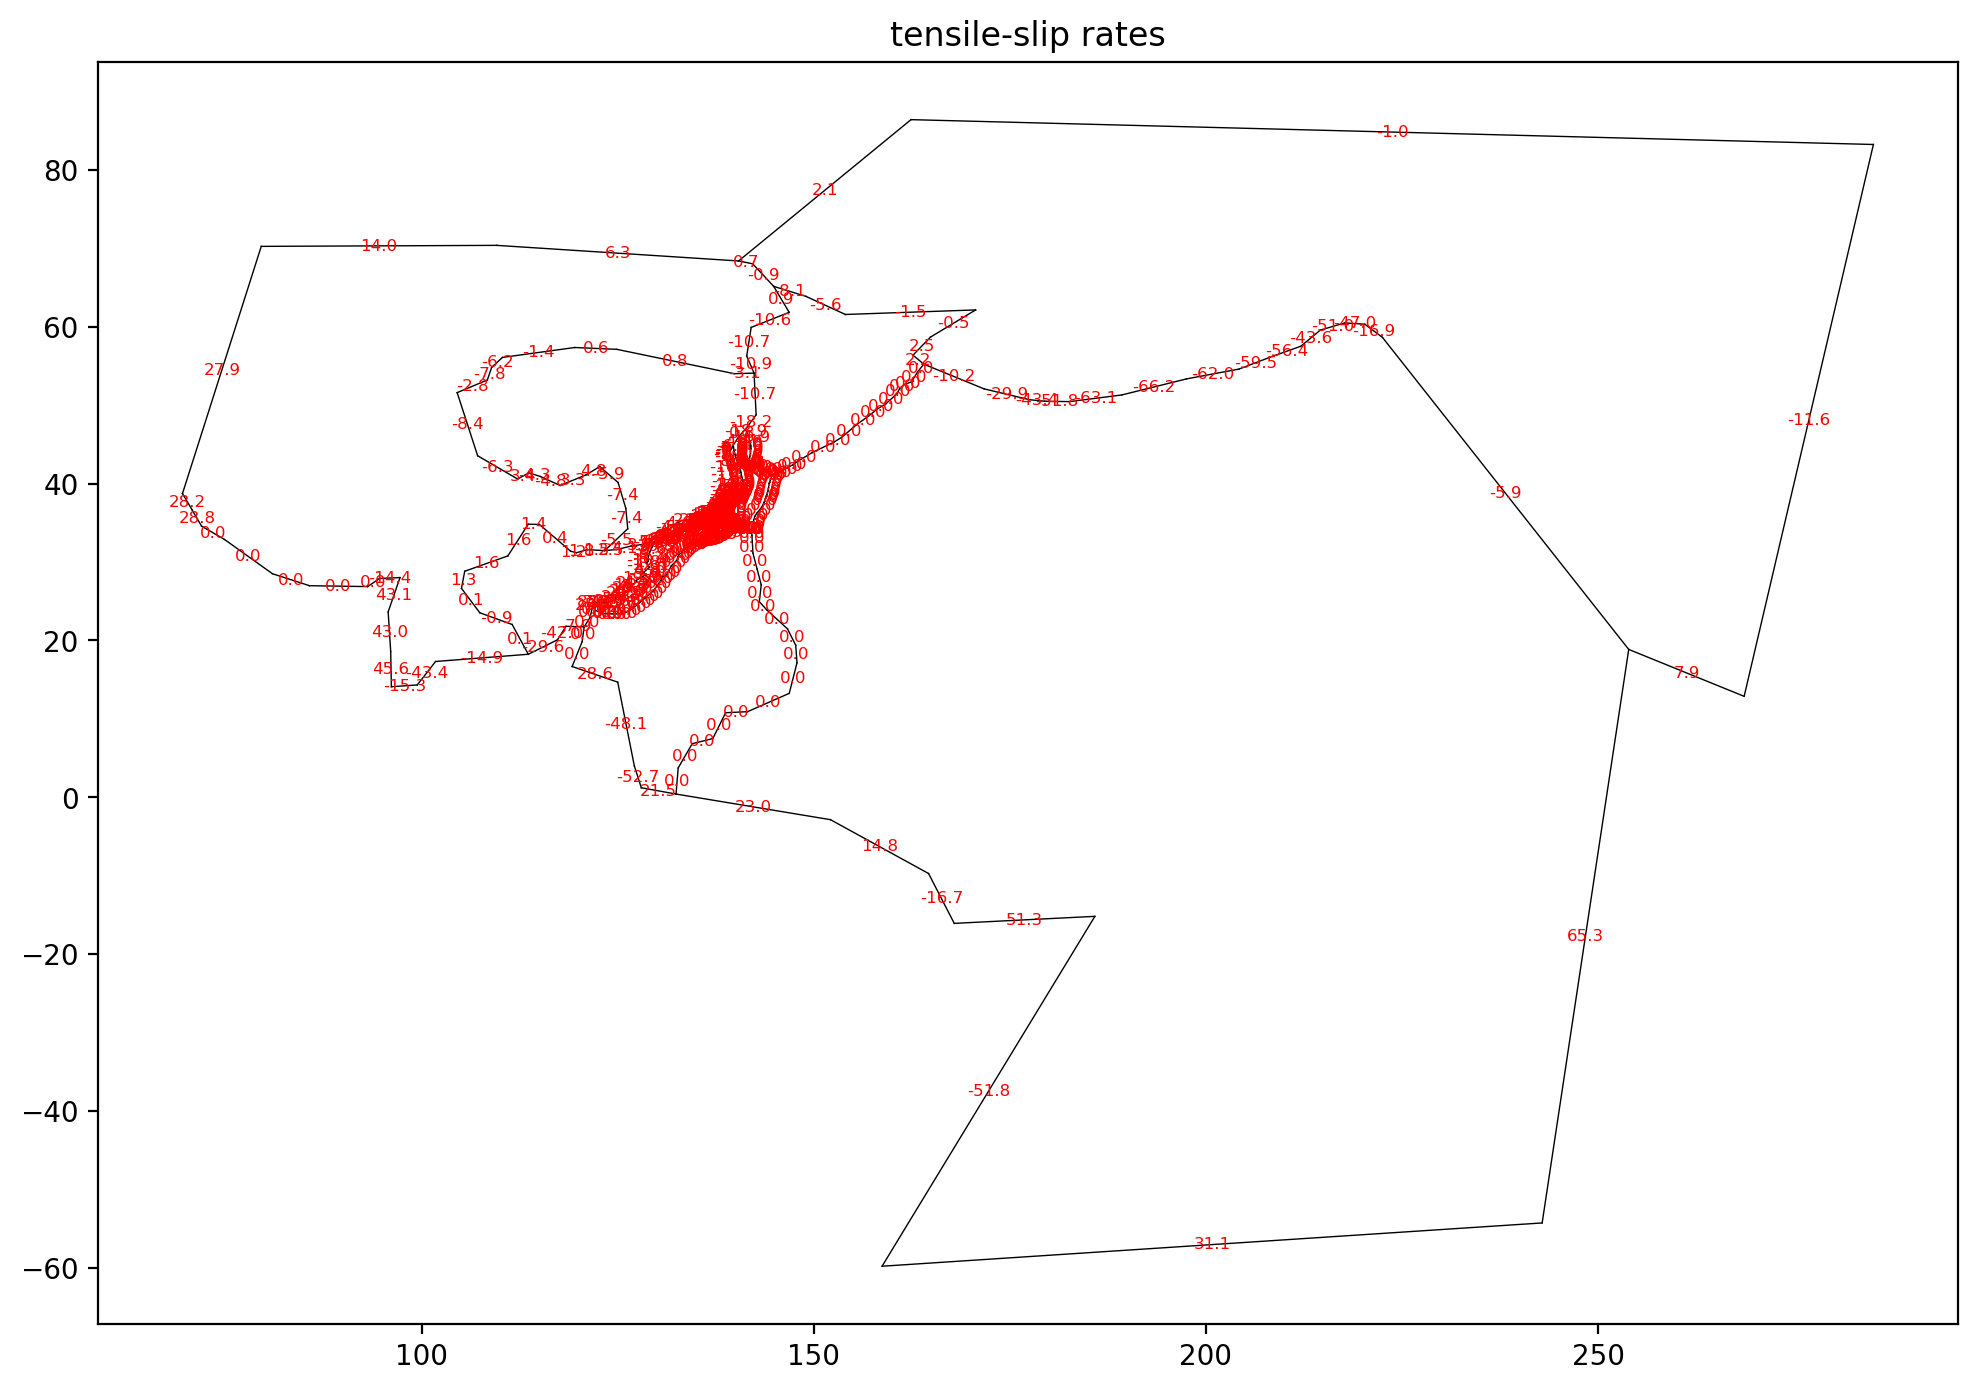

In [13]:
segment = model.segment


# estimated_slip_rates = operators.slip_rate_segment_block @ state_vector
estimated_slip_rates = operators.rotation_to_slip_rate @ state_vector

estimated_strike_slip_rates = estimated_slip_rates[0::3]
estimated_dip_slip_rates = estimated_slip_rates[1::3]
estimated_tensile_slip_rates = estimated_slip_rates[2::3]

plt.figure(figsize=(12, 12))
for i in range(len(segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
    plt.text(
        segment.mid_lon_plate_carree[i],
        segment.mid_lat_plate_carree[i],
        f"{estimated_strike_slip_rates[i]:.1f}",
        color="r",
        clip_on=True,
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )
plt.xlim([lon_min, lon_max])
plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("strike-slip rates")
plt.show()


plt.figure(figsize=(12, 12))
for i in range(len(segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
    plt.text(
        segment.mid_lon_plate_carree[i],
        segment.mid_lat_plate_carree[i],
        f"{estimated_dip_slip_rates[i]:.1f}",
        color="r",
        clip_on=True,
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )
# plt.xlim([lon_min, lon_max])
# plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("dip-slip rates")
plt.show()


plt.figure(figsize=(12, 12))
for i in range(len(segment)):
    plt.plot(
        [segment.lon1[i], segment.lon2[i]],
        [segment.lat1[i], segment.lat2[i]],
        "-k",
        linewidth=0.5,
    )
    plt.text(
        segment.mid_lon_plate_carree[i],
        segment.mid_lat_plate_carree[i],
        f"{estimated_tensile_slip_rates[i]:.1f}",
        color="r",
        clip_on=True,
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )
# plt.xlim([lon_min, lon_max])
# plt.ylim([lat_min, lat_max])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("tensile-slip rates")
plt.show()

# Summary of differential block motion/slip rate conventions:
| type | sign | interpretation |
| - | - | - |
| strike-slip | positive | left-lateral |
| strike-slip | negative | right-lateral |
| dip-slip | positive | convergence |
| dip-slip | negative | extension |
| tensile-slip | positive | extension |
| tensile-slip | negative | convergence |

Note: The difference in sign for convergence and extension for dip-slip and tensile-slip is not ideal but it seems consistent with Okada.  Should I change this so that it is more intiutive (e.g., positive numbers are always convergence) or leave as is for consistency with Okada?  To make the tensile slip rate consistent with Okada there is a scale_factor = -1 in celeri.get_fault_slip_rate_partials.